<a href="https://colab.research.google.com/github/kutaydemiralay/3DOF-Rocket-Landing-SCP-SciPy/blob/main/rocket_landing_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**General Nonlinear Optimizer Algorithm**

Libraries

In [13]:
import numpy as np
import jax.numpy as jnp
import scipy.optimize
import matplotlib.pyplot as plt
from time import time

Paramteres-Initial and Final Conditions

In [14]:

# Define constants related to the rocket's movement
x_dim = 6  # Number of state variables: [horizontal position, vertical position, horizontal speed, vertical speed, angle, angular speed]
u_dim = 2  # Number of control variables: [gimbal angle, thrust]
g = 1   # Gravity in meters per second squared
m = 2      # Mass of the rocket in kilograms
I = 0.01   # Moment of inertia in kilogram meter squared
r_TB = 0.01 # Distance from the center of mass to the thrust point
alphamass=0.1 #mass depletion rate

# Set limits on the control variables
T_max = 5   # Maximum thrust
T_min = T_max * 0.4  # Minimum thrust
max_gimbal = np.deg2rad(7)  # Maximum gimbal angle in radians

# Set limits on the state variables
t_max = np.deg2rad(60)  # Maximum angle in radians
w_max = np.deg2rad(60)  # Maximum angular speed in radians per second


# Define the final time desired
final_time_desired = 4  # seconds

K=75; # Number of trajectory points
t0_tm = time() #Start the timer

Functions and Solving the Problem


In [19]:
#Calculating mass depletion
def mass_depletion_rate(T_B):
    global alphamass
    return -alphamass * np.linalg.norm(T_B)


# Define the rocket's movement equations
def ode(state, control):
    rx, ry, vx, vy, theta, omega = state
    gimbal, thrust = control
    return np.array([
        vx,
        vy,
        np.sin(theta + gimbal) * thrust / m,
        (np.cos(theta + gimbal) * thrust - m * g) / m,
        omega,
        (-np.sin(gimbal) * thrust * r_TB) / I
    ])

# Implement the Runge-Kutta method for more accurate numerical integration
def rk4(func, y0, dt, control):
    h = dt
    k1 = h * func(y0, control)
    k2 = h * func(y0 + 0.5 * k1, control)
    k3 = h * func(y0 + 0.5 * k2, control)
    k4 = h * func(y0 + k3, control)
    return y0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Define how the rocket's state changes with time using the Runge-Kutta method, discretize
def discrete_step(state, control, dt):
    return rk4(ode, state, dt, control)

# Optimize the rocket's path to land it smoothly
def optimize_nominal_trajectory(N=75, final_time_desired=final_time_desired, return_optimize_result=False):
    x_0 = np.array([4., 4., -2., -1., 0., 0.])  # Initial state
    x_f = np.array([0., 0., 0., 0., 0., 0.])  # Final state

    Q = np.eye(x_dim)  # State cost matrix
    R = np.eye(u_dim)  # Control cost matrix
    Q_final = 100 * np.eye(x_dim)  # Final state cost matrix

    def pack_decision_variables(final_time, states, controls):
        return np.concatenate([[final_time], states.ravel(), controls.ravel()])

    def unpack_decision_variables(z):
        final_time = z[0]
        states = z[1:1 + (N + 1) * x_dim].reshape(N + 1, x_dim)
        controls = z[-N * u_dim:].reshape(N, u_dim)
        return final_time, states, controls

    def cost(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N #step size

        control_cost = sum(controls[k].T @ R @ controls[k] for k in range(N))
        return control_cost

    z_guess = pack_decision_variables(
        final_time_desired,
        x_0 + np.linspace(0, 1, N + 1)[:, np.newaxis] * (x_f - x_0),
        np.vstack((np.zeros(N), np.full(N, (T_max + T_min) / 2))).T
    )

    lower_bounds_states = np.tile([-np.inf, -np.inf, -np.inf, -np.inf, -t_max, -w_max], (N + 1, 1)).ravel()
    upper_bounds_states = np.tile([np.inf, np.inf, np.inf, np.inf, t_max, w_max], (N + 1, 1)).ravel()

    lower_bounds_controls = np.tile([-max_gimbal, T_min], (N, 1)).ravel()
    upper_bounds_controls = np.tile([max_gimbal, T_max], (N, 1)).ravel()

    lower_bounds = np.concatenate([[0], lower_bounds_states, lower_bounds_controls])
    upper_bounds = np.concatenate([[np.inf], upper_bounds_states, upper_bounds_controls])

    bounds = scipy.optimize.Bounds(lower_bounds, upper_bounds)

    def equality_constraints(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        constraint_list = [states[i + 1] - discrete_step(states[i], controls[i], dt) for i in range(N)]
        constraint_list.append(states[0] - x_0)  # Initial state constraint
        constraint_list.append(states[-1] - x_f)  # Final state constraint
        return np.concatenate(constraint_list)

    result = scipy.optimize.minimize(cost,
                                 z_guess,
                                 bounds=bounds,
                                 constraints=[{"type": "eq", "fun": equality_constraints}],
                                 options={'disp': True, 'tol': 1e-10, 'ftol': 1e-10})  # Enable verbose output, Adjust tolerance settings


    final_time, states, controls = unpack_decision_variables(result.x)


    # Print the final state
    print("Final State:")
    print(states[-1])

    total_time = time() - t0_tm

    if return_optimize_result:
        return result, total_time
    return (final_time, states, controls), total_time, result.nit  # Return number of iterations



Prinitng and Plotting the Results

<ipython-input-19-872c3b1c5ffb>:83: OptimizeWarning: Unknown solver options: tol
  result = scipy.optimize.minimize(cost,


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 693.4625981499853
            Iterations: 37
            Function evaluations: 20239
            Gradient evaluations: 33
Final State:
[ 2.09382402e-15  2.35732681e-16  1.01866196e-15  2.32451722e-15
 -4.97355385e-16 -4.68133573e-16]


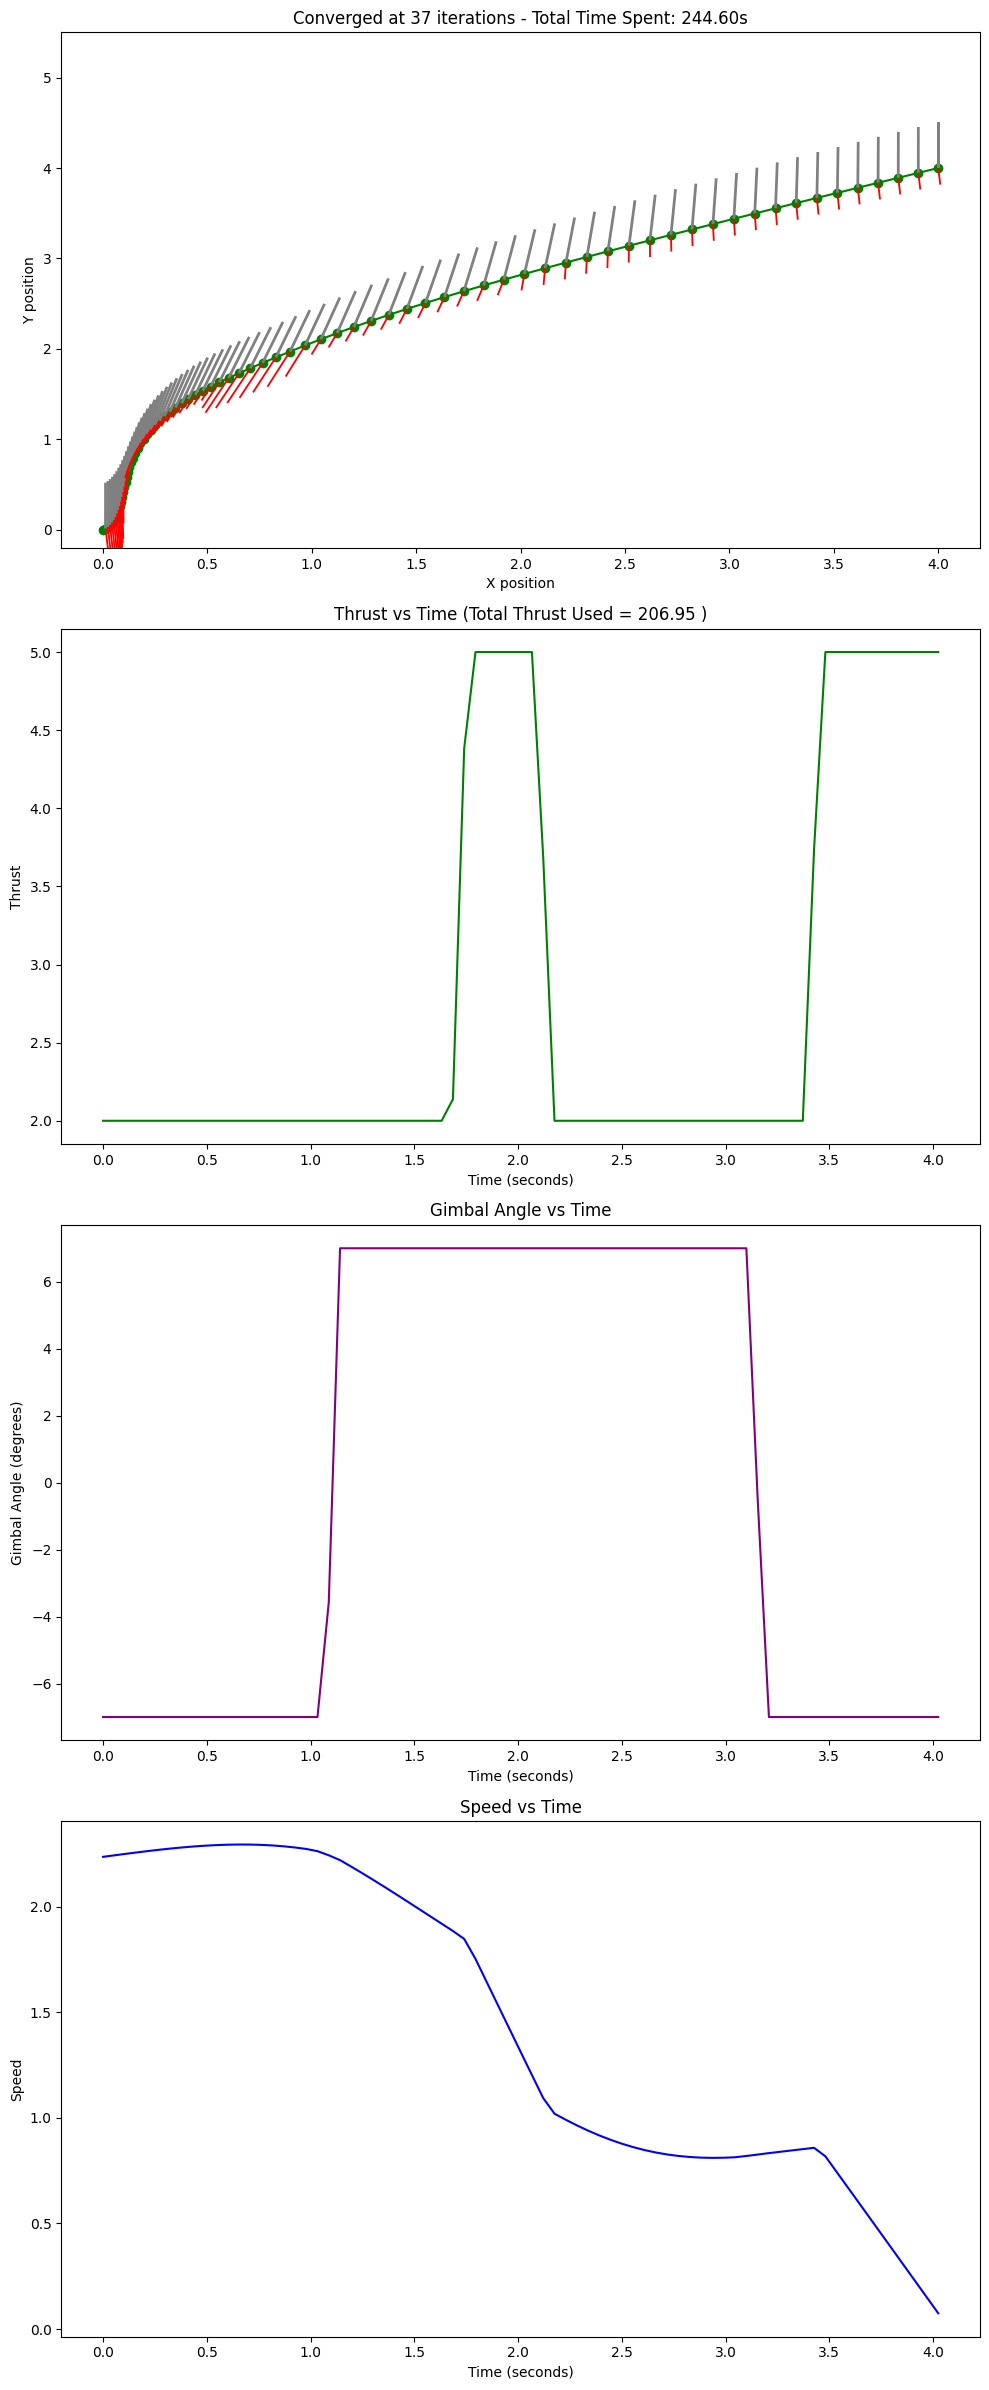

Total thrust used in all time steps: 206.95 


In [20]:


def my_plot(fig, states, controls, final_time, total_time, nit, total_thrust):

    attitude_scale = 20
    thrust_scale = 110

    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    N = states.shape[0] - 1
    time_in_sec = np.linspace(0, final_time, N)

    # Position plot
    ax1.set_xlabel('X position')
    ax1.set_ylabel('Y position')
    ax1.plot(states[:, 0], states[:, 1], color='green', zorder=0)
    ax1.scatter(states[:, 0], states[:, 1], color='green', zorder=1)  # Adding dots at each iteration point
    rx, ry = states[:-1, 0], states[:-1, 1]
    dx, dy = np.sin(states[:-1, 4]), np.cos(states[:-1, 4])
    Fx, Fy = -np.sin(states[:-1, 4] + controls[:, 0]) * controls[:, 1], -np.cos(states[:-1, 4] + controls[:, 0]) * controls[:, 1]
    ax1.quiver(rx, ry, dx, dy, color='grey', width=0.003, scale=attitude_scale, headwidth=1, headlength=0)
    ax1.quiver(rx, ry, Fx, Fy, color='red', width=0.002, scale=thrust_scale, headwidth=1, headlength=0)
    ax1.set_title(f"Converged at {nit} iterations - Total Time Spent: {total_time:.2f}s")
    ax1.set_ylim([None, np.max(ry) + 1.5])

    # Thrust plot
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Thrust')
    ax2.plot(time_in_sec, controls[:, 1], color='green')
    ax2.set_title(f"Thrust vs Time (Total Thrust Used = {total_thrust:.2f} )")

    # Gimbal angle plot
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Gimbal Angle (degrees)')
    gimbal_angles_deg = np.rad2deg(controls[:, 0])
    ax3.plot(time_in_sec, gimbal_angles_deg, color='purple')
    ax3.set_title("Gimbal Angle vs Time")

    # Speed plot
    speed = np.sqrt(states[:-1, 2]**2 + states[:-1, 3]**2)
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Speed')
    ax4.plot(time_in_sec, speed, color='blue')
    ax4.set_title("Speed vs Time")

    fig.tight_layout()

def plot_trajectory(states, controls, final_time, total_time, nit, total_thrust):
    fig = plt.figure(figsize=(10, 24))
    my_plot(fig, states, controls, final_time, total_time, nit, total_thrust)
    plt.show()

# Solving problem
(final_time, nominal_states, nominal_controls), total_time, nit = optimize_nominal_trajectory(final_time_desired=final_time_desired)

# Calculate the total thrust used
total_thrust = np.sum(nominal_controls[:, 1])

# Plot
plot_trajectory(nominal_states, nominal_controls, final_time, total_time, nit, total_thrust)

print(f"Total thrust used in all time steps: {total_thrust:.2f} ")
